In [1]:
# library imports
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import random
from transformers import AutoTokenizer

114280 38504


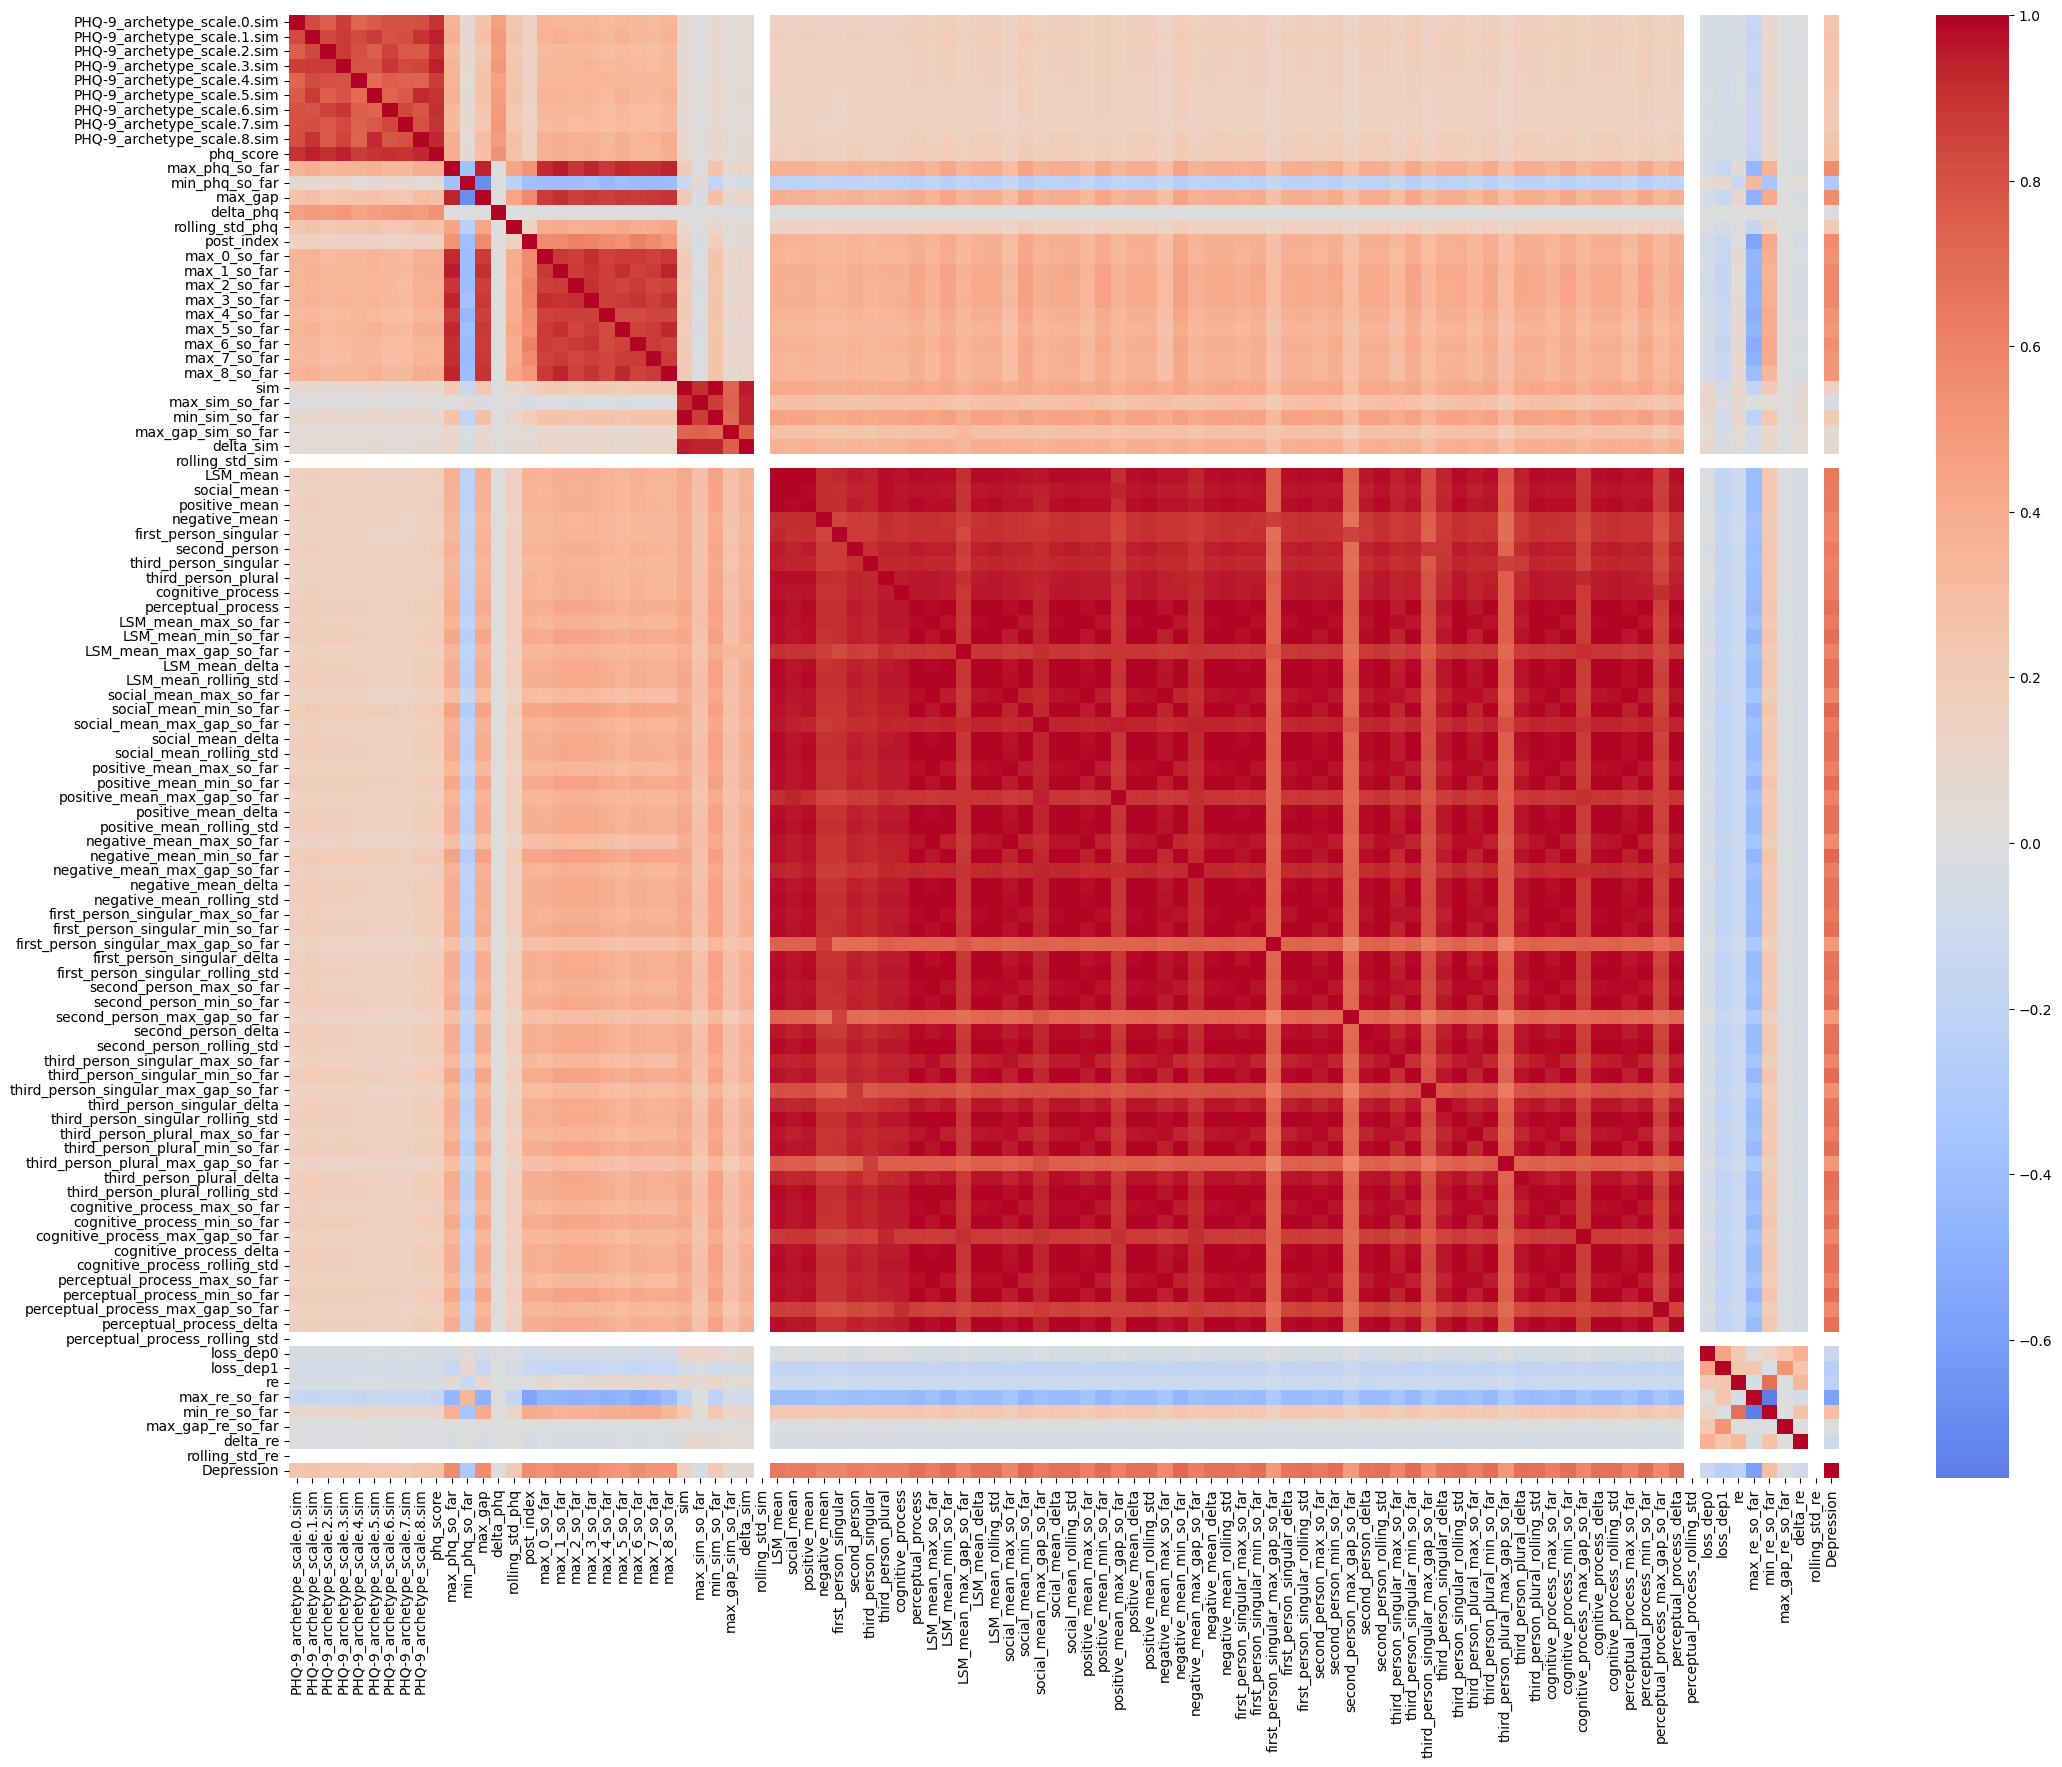

['PHQ-9_archetype_scale.0.sim', 'PHQ-9_archetype_scale.1.sim', 'PHQ-9_archetype_scale.2.sim', 'PHQ-9_archetype_scale.3.sim', 'PHQ-9_archetype_scale.4.sim', 'PHQ-9_archetype_scale.5.sim', 'PHQ-9_archetype_scale.6.sim', 'PHQ-9_archetype_scale.7.sim', 'PHQ-9_archetype_scale.8.sim', 'phq_score', 'max_phq_so_far', 'min_phq_so_far', 'max_gap', 'delta_phq', 'rolling_std_phq', 'post_index', 'max_0_so_far', 'max_1_so_far', 'max_2_so_far', 'max_3_so_far', 'max_4_so_far', 'max_5_so_far', 'max_6_so_far', 'max_7_so_far', 'max_8_so_far', 'sim', 'max_sim_so_far', 'min_sim_so_far', 'max_gap_sim_so_far', 'delta_sim', 'rolling_std_sim', 'LSM_mean', 'social_mean', 'positive_mean', 'negative_mean', 'first_person_singular', 'second_person', 'third_person_singular', 'third_person_plural', 'cognitive_process', 'perceptual_process', 'LSM_mean_max_so_far', 'LSM_mean_min_so_far', 'LSM_mean_max_gap_so_far', 'LSM_mean_delta', 'LSM_mean_rolling_std', 'social_mean_max_so_far', 'social_mean_min_so_far', 'social_mean

In [2]:
# load data
train=pd.read_pickle('../Features/final_training_dataset.pickle')
train = train.dropna(subset=['body','re'])
test=pd.read_pickle('../Features/final_testing_dataset.pickle')
test = test.dropna(subset=['body','re'])

# define feature columns
drop_cols = ['body','parent_body','user_id','created_utc','type','Depression','key','parent','title',
             'submission_id','parent_id','comment_id','target']

feature_cols = [c for c in train.columns if c not in drop_cols]
train[feature_cols] = train[feature_cols].apply(pd.to_numeric, errors='coerce')
test[feature_cols]  = test[feature_cols].apply(pd.to_numeric, errors='coerce')

train[feature_cols] = train[feature_cols].fillna(-1)
test[feature_cols]  = test[feature_cols].fillna(-1)


print(len(train), len(test))

# Correlation heatmap
corr = train[feature_cols + ["Depression"]].corr()

plt.figure(figsize=(25,19))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.show()
print(feature_cols)


In [27]:
# Helper functions and classes for user-level Transformer model
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


# Function to create sequences of user data for RNN input
def make_sequences(df, feature_cols):
    X_seqs = []
    y_labels = []
    
    # Group by user_id to create sequences
    for uid, g in df.groupby("user_id"):
        # Sort by created_utc to maintain temporal order
        g = g.sort_values("created_utc")
        # Extract feature columns and convert to tensor
        seq = torch.tensor(g[feature_cols].values, dtype=torch.float32)
        X_seqs.append(seq)
        # Depression or not
        y_labels.append(int(g["Depression"].max()))

    y_labels = torch.tensor(y_labels, dtype=torch.float32)

    return X_seqs, y_labels

# Collate function to pad sequences and create attention masks
def collate_fn(batch):
    seqs, labels = zip(*batch)

    padded = pad_sequence(seqs, batch_first=True)
    attention_mask = (padded.sum(dim=-1) != 0).long()
    labels = torch.tensor(labels, dtype=torch.float32)
    return padded, attention_mask, labels

# Custom Dataset class for user sequences
class UserSeqDataset(Dataset):
    def __init__(self, X_seqs, y):
        self.X = X_seqs
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Transformer-based model for user classification
class TransformerUserClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, n_heads=4, n_layers=3):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            batch_first=True,
            dropout=0.1
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Using mean pooling for classification
        self.cls_head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, attention_mask, return_sequence=False):
        x = self.input_proj(x)
        src_key_padding_mask = (attention_mask == 0)
        out = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        
        token_logits = self.cls_head(out).squeeze(-1)   # shape [B, T]
    
        if return_sequence:
            return token_logits  

        out_masked = out.masked_fill(src_key_padding_mask.unsqueeze(-1), 0.0)
        valid_len = attention_mask.sum(dim=1).unsqueeze(-1)

        pooled = out_masked.sum(dim=1) / valid_len

        return self.cls_head(pooled).squeeze(1)
    
# Function to split data into training and validation sets at user level 
def user_split(df, val_ratio=0.15):
    users = df["user_id"].unique()
    labels = df.groupby("user_id")["Depression"].max()

    train_users, val_users = train_test_split(
        users,
        test_size=val_ratio,
        random_state=42,
        stratify=labels
    )

    df_train = df[df.user_id.isin(train_users)]
    df_val = df[df.user_id.isin(val_users)]

    return df_train, df_val

# Training function for the Transformer model
def train_model(model, train_loader, val_loader, epochs=30, lr=1e-4 ):
    device = next(model.parameters()).device
    pos_weight=torch.tensor([1], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    best_val_loss = 1e10
    patience = 5
    patience_counter = 0

    for ep in range(1, epochs+1):
        model.train()
        total_train_loss = 0

        for x, mask, y in train_loader:
            x, mask, y = x.to(device), mask.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x, mask)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, mask, y in val_loader:
                x, mask, y = x.to(device), mask.to(device), y.to(device)
                logits = model(x, mask)
                loss = criterion(logits, y)
                total_val_loss += loss.item()

        print(f"Epoch {ep}: Train Loss={total_train_loss/len(train_loader):.4f}, "
              f"Val Loss={total_val_loss/len(val_loader):.4f}")

        # Early stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping!")
                break

    model.load_state_dict(best_state)

# Evaluation function for the Transformer model
def evaluate_model(model, test_loader):
    device = next(model.parameters()).device
    model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for x, mask, y in test_loader:
            x, mask = x.to(device), mask.to(device)
            logits = model(x, mask).cpu()
            all_logits.append(logits)
            all_labels.append(y)

    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()

    prob = torch.sigmoid(torch.tensor(logits)).numpy()
    pred = (prob >= 0.5).astype(int)

    print("==== Test Performance ====")
    print("Accuracy :", accuracy_score(labels, pred))
    print("Precision:", precision_score(labels, pred))
    print("Recall   :", recall_score(labels, pred))
    print("F1 Score :", f1_score(labels, pred))
    print("ROC-AUC  :", roc_auc_score(labels, prob))


In [28]:
# User level prediction with Transformer
# prepare data loaders
test["created_utc"] = pd.to_datetime(test["created_utc"])
train["created_utc"] = pd.to_datetime(train["created_utc"])

train_user, val_user= user_split(train)

X_train, y_train = make_sequences(train_user, feature_cols)
X_val, y_val = make_sequences(val_user, feature_cols)
X_test, y_test = make_sequences(test, feature_cols)

train_loader = DataLoader(UserSeqDataset(X_train, y_train), batch_size=16, shuffle=False, collate_fn=collate_fn)
val_loader   = DataLoader(UserSeqDataset(X_val, y_val), batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(UserSeqDataset(X_test, y_test), batch_size=16, shuffle=False, collate_fn=collate_fn)

# initialize and train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerUserClassifier(input_dim=len(feature_cols)).to(device)
train_model(model, train_loader, val_loader, epochs=30)
#  Evaluate the model
evaluate_model(model, test_loader)

Epoch 1: Train Loss=0.3014, Val Loss=0.1533
Epoch 2: Train Loss=0.1066, Val Loss=0.0666
Epoch 3: Train Loss=0.0656, Val Loss=0.0368
Epoch 4: Train Loss=0.0683, Val Loss=0.0351
Epoch 5: Train Loss=0.0361, Val Loss=0.0156
Epoch 6: Train Loss=0.0282, Val Loss=0.0099
Epoch 7: Train Loss=0.0417, Val Loss=0.0066
Epoch 8: Train Loss=0.0216, Val Loss=0.0047
Epoch 9: Train Loss=0.0153, Val Loss=0.0144
Epoch 10: Train Loss=0.0140, Val Loss=0.0101
Epoch 11: Train Loss=0.0125, Val Loss=0.0403
Epoch 12: Train Loss=0.0070, Val Loss=0.0305
Epoch 13: Train Loss=0.0024, Val Loss=0.0443
Early stopping!
==== Test Performance ====
Accuracy : 0.9273743016759777
Precision: 0.6176470588235294
Recall   : 1.0
F1 Score : 0.7636363636363637
ROC-AUC  : 0.9981916817359855


In [31]:
# Save best model for deployment
import os

model_save_path = "best_model.pt"
torch.save(model.state_dict(), model_save_path)
print(f"Saved in: {model_save_path}")


# Save in Test
test_model_path = "../Test/best_model.pt"
os.makedirs(os.path.dirname(test_model_path), exist_ok=True)
torch.save(model.state_dict(), test_model_path)
print(f"Saved in: {test_model_path}")

Saved in: best_model.pt
Saved in: ../Test/best_model.pt


In [18]:
# find early detection POINT
def infer_post_prob(model, df, feature_cols):
    model.eval()
    device = next(model.parameters()).device

    results = {}

    for uid, g in df.groupby("user_id"):
        g = g.sort_values("created_utc")
        seq = torch.tensor(g[feature_cols].values, dtype=torch.float32).unsqueeze(0).to(device)
        mask = torch.ones(seq.size()[:2]).long().to(device)

        with torch.no_grad():
            logits = model(seq, mask, return_sequence=True)[0].cpu().numpy()
            prob = torch.sigmoid(torch.tensor(logits)).numpy()

        results[uid] = dict(
            prob_seq = prob,
            posts = g["comment_id"].tolist(),
            label = int(g["Depression"].max())
        )

    return results
post_results = infer_post_prob(model, test, feature_cols)

def eval_delay(post_results, th=0.5, k=0, method=''):
    out=[]

    for uid,r in post_results.items():
        p = r["prob_seq"]
        posts = r["posts"]
        y = r["label"]
        
        detect_idx=None

        if method=="max":        # Max
            idx=np.argmax(p)
            if p[idx]>=th: detect_idx=idx

        elif method=="mean":     # Mean
            if np.mean(p)>=th:
                detect_idx=next((i for i,x in enumerate(p) if x>=th),None)

        elif method=="topk":     # top-k
            top=np.argsort(p)[-k:]
            if np.mean(p[top])>=th:
                detect_idx=min(top)

        elif method=="consecutive":  # consecutive K
            cnt=0
            for i,x in enumerate(p):
                cnt=cnt+1 if x>=th else 0
                if cnt>=k: detect_idx=i; break
        
        out.append([
            uid,y,
            1 if detect_idx is not None else 0,
            posts[detect_idx] if detect_idx is not None else None,
            detect_idx   # ← delay
        ])

    df=pd.DataFrame(out,columns=["user_id","label","pred","decision_post","delay"])
    return df

df_delay = eval_delay(post_results, th=0.5, k=6, method="consecutive")
print(df_delay.head())

true=df_delay["label"]
pred=df_delay["pred"]

print("Acc =",accuracy_score(true,pred))
print("Pre =",precision_score(true,pred))
print("Rec =",recall_score(true,pred))
print("F1  =",f1_score(true,pred))
print("\n Average delay =", df_delay['delay'].dropna().mean())
print("Mid delay =", df_delay['delay'].dropna().median())
print(df_delay.columns)


           user_id  label  pred decision_post  delay
0  subject_08eA70p      0     0          None    NaN
1  subject_0ROAtkI      0     0          None    NaN
2  subject_0bCCxpq      0     0          None    NaN
3  subject_0sOkMfd      0     0          None    NaN
4  subject_16b6b7C      0     0          None    NaN
Acc = 0.9720670391061452
Pre = 0.8333333333333334
Rec = 0.9523809523809523
F1  = 0.8888888888888888

 Average delay = 5.625
Mid delay = 5.0
Index(['user_id', 'label', 'pred', 'decision_post', 'delay'], dtype='object')


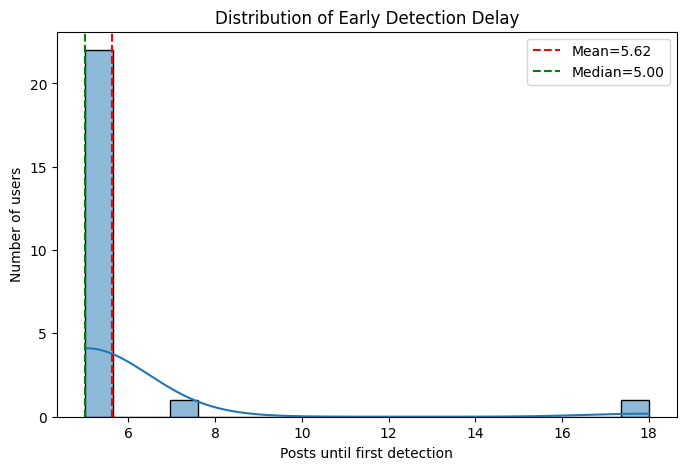

In [19]:

delay = df_delay['delay']

plt.figure(figsize=(8,5))
sns.histplot(delay, bins=20, kde=True)
plt.axvline(delay.mean(), color='red', linestyle='--', label=f"Mean={delay.mean():.2f}")
plt.axvline(delay.median(), color='green', linestyle='--', label=f"Median={delay.median():.2f}")
plt.legend()
plt.title("Distribution of Early Detection Delay")
plt.xlabel("Posts until first detection")
plt.ylabel("Number of users")
plt.show()

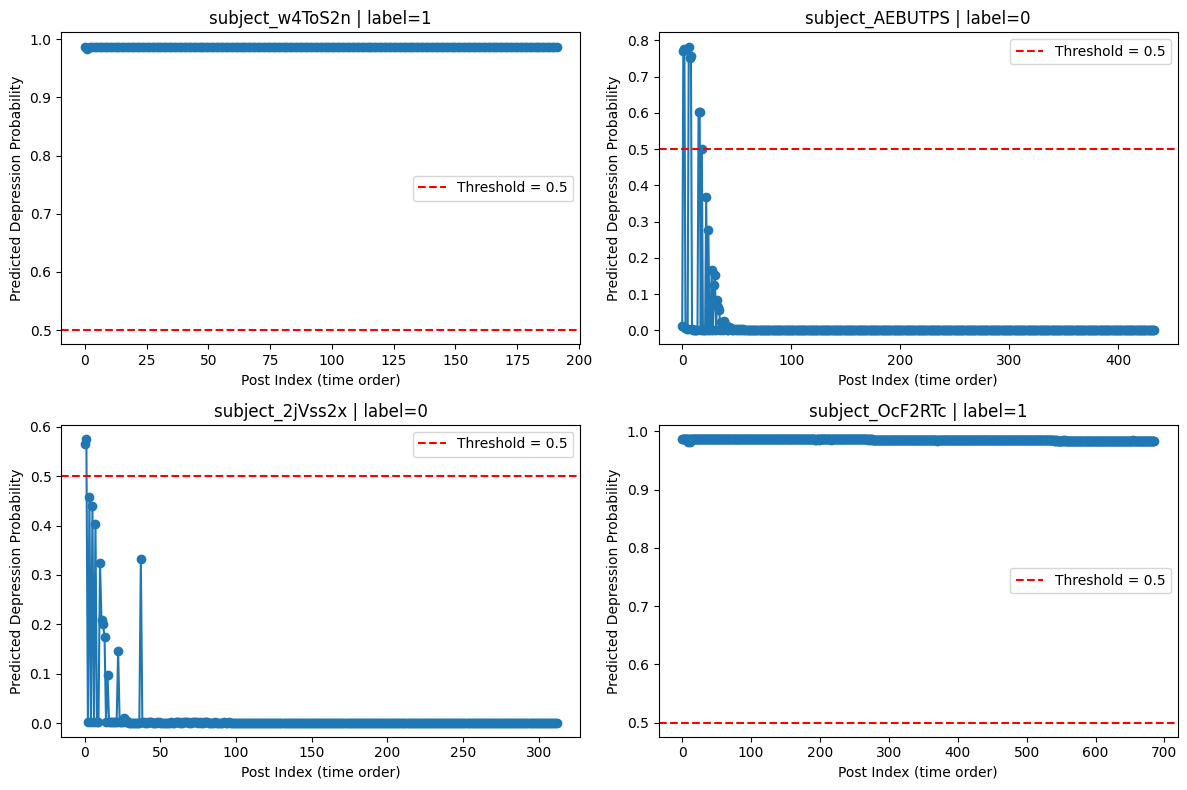

In [20]:
sample_users = random.sample(list(post_results.keys()), 4)

plt.figure(figsize=(12,8))
for i,uid in enumerate(sample_users):
    p = post_results[uid]["prob_seq"]
    plt.subplot(2,2,i+1)

    plt.plot(p, marker='o')
    plt.axhline(0.5, color='red', linestyle='--', label='Threshold = 0.5')

    plt.xlabel("Post Index (time order)")
    plt.ylabel("Predicted Depression Probability")

    plt.title(f"{uid} | label={post_results[uid]['label']}")

    plt.legend()

plt.tight_layout()
plt.show()


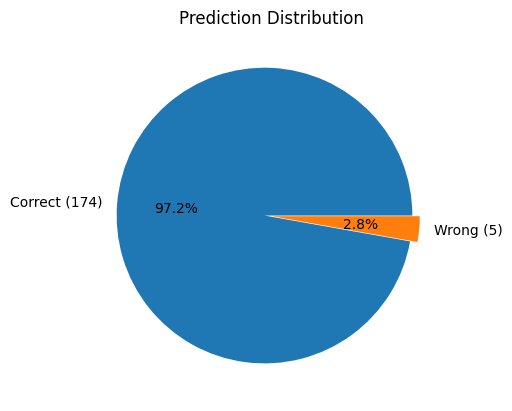

In [21]:
correct = (true==pred).sum()
wrong   = (true!=pred).sum()

plt.pie([correct,wrong],
        labels=[f"Correct ({correct})",f"Wrong ({wrong})"],
        autopct="%1.1f%%",
        explode=[0.05,0])
plt.title("Prediction Distribution")
plt.show()

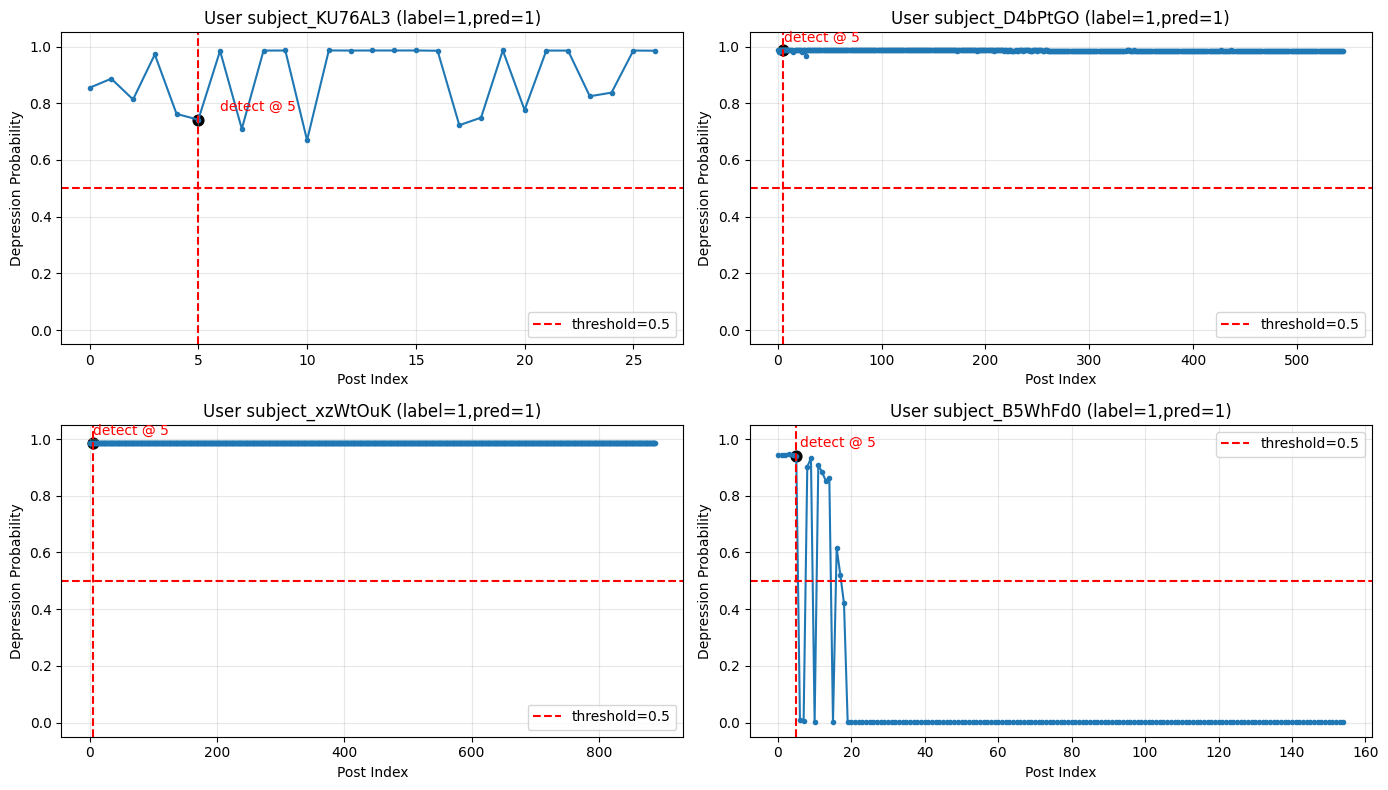

In [22]:
import random

def plot_batch_users(n=4, threshold=0.5):
    dep_users = df_delay[df_delay.pred==1].user_id.tolist()
    sample_users = random.sample(dep_users, min(n,len(dep_users)))

    plt.figure(figsize=(14,8))

    for i,uid in enumerate(sample_users):
        r = post_results[uid]
        p = np.array(r["prob_seq"])
        delay = df_delay.loc[df_delay.user_id==uid,"delay"].values[0]
        label = r["label"]

        plt.subplot(2,2,i+1)
        plt.plot(p, marker='o', markersize=3)
        plt.axhline(threshold, color='red', linestyle='--', label=f"threshold={threshold}")

        if not np.isnan(delay):
            delay = int(delay)
            plt.axvline(delay, color='red', linestyle='--')
            plt.scatter(delay, p[delay], s=60, color='black')
            plt.text(delay+1, p[delay]+0.03, f"detect @ {delay}", color='red')

        plt.title(f"User {uid} (label=1,pred=1)")
        plt.xlabel("Post Index")
        plt.ylabel("Depression Probability")
        plt.ylim(-0.05,1.05)
        plt.grid(alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_batch_users(4)   


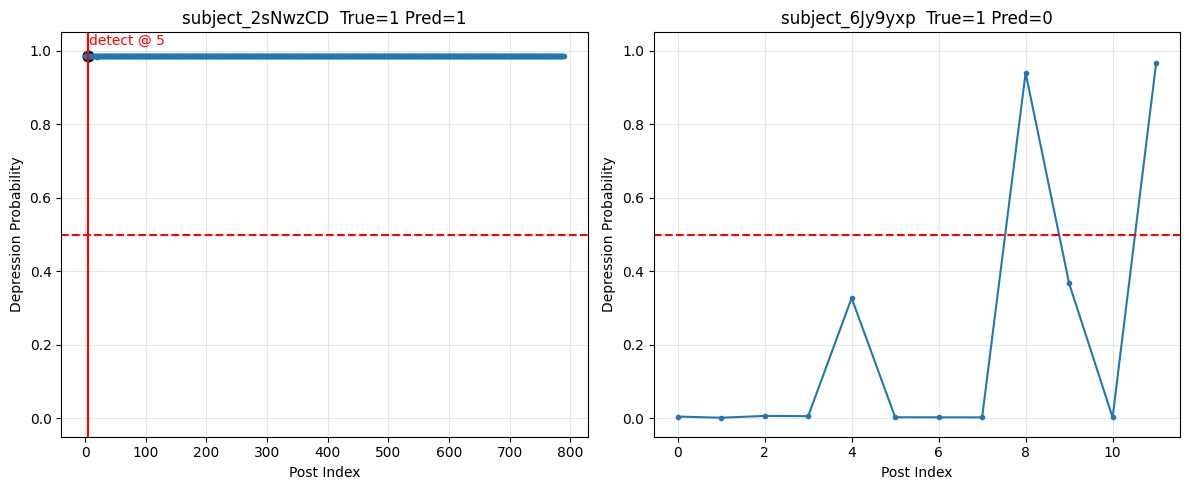

In [23]:
def plot_compare_success_fail(threshold=0.5):

    true_pos  = df_delay[(df_delay.label==1) & (df_delay.pred==1)].user_id.tolist()[:1]
    false_neg = df_delay[(df_delay.label==1) & (df_delay.pred==0)].user_id.tolist()[:1]

    if len(false_neg)==0:

        return

    users = true_pos + false_neg  

    plt.figure(figsize=(12,5))

    for i,uid in enumerate(users):
        r = post_results[uid]
        p = np.array(r["prob_seq"])
        delay = df_delay.loc[df_delay.user_id==uid,"delay"].values[0]
        label = r["label"]
        pred  = df_delay.loc[df_delay.user_id==uid,"pred"].values[0]

        plt.subplot(1,2,i+1)
        plt.plot(p, marker='o', markersize=3)
        plt.axhline(threshold, color='red', linestyle='--')

        if not np.isnan(delay) and pred==1:
            delay=int(delay)
            plt.axvline(delay, color='red')
            plt.scatter(delay,p[delay],s=60,color='black')
            plt.text(delay+1,p[delay]+0.03,f"detect @ {delay}",color='red')

        plt.title(f"{uid}  True={label} Pred={pred}")
        plt.xlabel("Post Index")
        plt.ylabel("Depression Probability")
        plt.ylim(-0.05,1.05)
        plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_compare_success_fail()


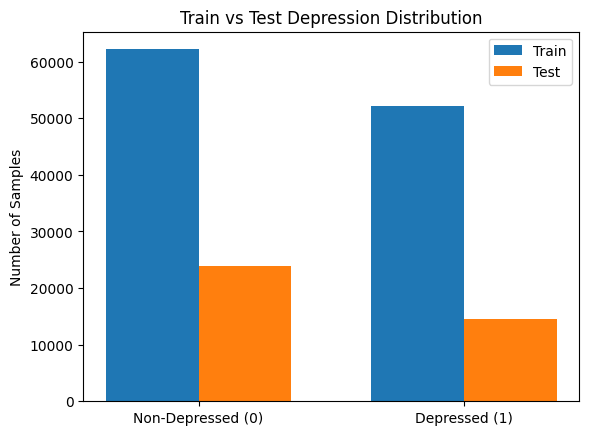

In [24]:
train_counts = train['Depression'].value_counts().sort_index()
test_counts  = test['Depression'].value_counts().sort_index()

labels = ['Non-Depressed (0)', 'Depressed (1)']
x = np.arange(len(labels))
width = 0.35  # bar width

plt.figure()
plt.bar(x - width/2, train_counts, width, label='Train')
plt.bar(x + width/2, test_counts,  width, label='Test')

plt.xticks(x, labels)
plt.ylabel('Number of Samples')
plt.title('Train vs Test Depression Distribution')
plt.legend()
plt.show()

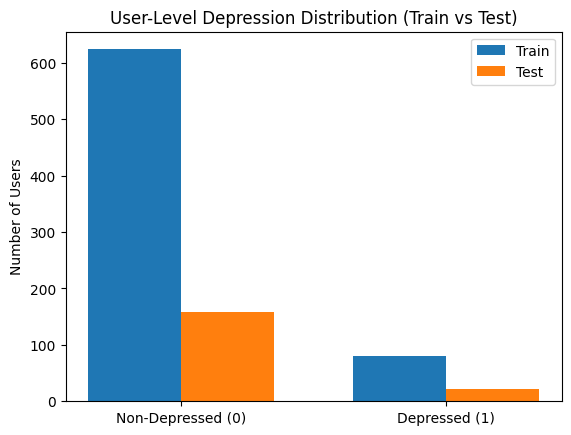

In [25]:
# Convert to user-level depression label:

train_user_label = train.groupby('user_id')['Depression'].max()
test_user_label  = test.groupby('user_id')['Depression'].max()

# Count distribution
train_counts = train_user_label.value_counts().sort_index()
test_counts  = test_user_label.value_counts().sort_index()

x = np.arange(len(labels))
width = 0.35

plt.figure()
plt.bar(x - width/2, train_counts, width, label='Train')
plt.bar(x + width/2, test_counts, width, label='Test')

plt.xticks(x, labels)
plt.ylabel('Number of Users')
plt.title('User-Level Depression Distribution (Train vs Test)')
plt.legend()
plt.show()